## Requirements

In [ ]:
!pip install nltk
!pip install numpy
!pip install pandas
!pip install textblob
!pip install scikit-learn
!pip install IPython
!pip install matplotlib
!pip install seaborn
!pip install wordninja
!pip install wordcloud

In [2]:
import re
import nltk
import time
import wordninja
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

from datetime import timedelta
from textblob import TextBlob 
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from IPython.display import display, HTML

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/jgonzalez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jgonzalez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jgonzalez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jgonzalez/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Data Loading

In [3]:
df = pd.read_csv('data/tripadvisor_hotel_reviews-balanced.csv')
df = df.rename(columns={'Review': 'review', 'Rating': 'rating'})

In [4]:
df.head(5)

,review,rating
0,nice hotel expensive parking got good deal sta...,4
1,Title: A Disaster of a Stay: Avoid This Hotel ...,1
2,My recent stay at this hotel was a catastrophe...,1
3,"Despite its promising name, ""Paradise Haven"" f...",1
4,I will preface this review by stating that I h...,1


In [5]:
df.shape

(20508, 2)

In [7]:
df['three_classes'] = df['rating'].replace({
    1: 0, 2: 0,  # Agrupa 1 y 2 como 0
    3: 1,        # Deja 3 como 1
    4: 2, 5: 2   # Agrupa 4 y 5 como 2
})

In [8]:
df.head()

,review,rating,three_classes
0,nice hotel expensive parking got good deal sta...,4,2
1,Title: A Disaster of a Stay: Avoid This Hotel ...,1,0
2,My recent stay at this hotel was a catastrophe...,1,0
3,"Despite its promising name, ""Paradise Haven"" f...",1,0
4,I will preface this review by stating that I h...,1,0


## Data Pre-processing

### Pre-processing functions and test

#### Plot and aesthetic

In [10]:
def highlight_differences(text1, text2):
    words1 = set(text1.split())
    words2 = set(text2.split())
    
    different_words = words1.symmetric_difference(words2)
    
    html = f"""
    <div style="display: flex; gap: 20px;">
        <div style="flex: 1;">
            <h4>Original:</h4>
            <p>{''.join([f'<span style="background-color: orange">{w}</span> ' if w in different_words else f'{w} ' for w in text1.split()])}</p>
        </div>
        <div style="flex: 1;">
            <h4>Cleaned:</h4>
            <p>{''.join([f'<span style="background-color: orange">{w}</span> ' if w in different_words else f'{w} ' for w in text2.split()])}</p>
        </div>
    </div>
    """
    return HTML(html)

def create_rating_wordcloud(df, rating=None, 
                          title=None,
                          width=800, 
                          height=400,
                          background_color='white',
                          colormap='viridis',
                          max_words=100):
    """
    Create word cloud from reviews with specific rating(s)
    
    Parameters:
    - df: pandas DataFrame with 'rating' and 'cleaned_review' columns
    - rating: int or list of ints (1-5), if None shows all reviews
    - title: custom title, if None auto-generates based on rating
    """
    
    # Filter by rating if specified
    if rating is not None:
        if isinstance(rating, (int, float)):
            df_filtered = df[df['rating'] == rating]
            default_title = f'Word Cloud - Rating {rating}'
        elif isinstance(rating, list):
            df_filtered = df[df['rating'].isin(rating)]
            default_title = f'Word Cloud - Ratings {rating}'
    else:
        df_filtered = df
        default_title = 'Word Cloud - All Ratings'
    
    # Check if we have reviews
    if len(df_filtered) == 0:
        print(f"No reviews found for rating(s): {rating}")
        return None
    
    # Combine all filtered reviews
    text = ' '.join(df_filtered['cleaned_review'].astype(str))
    
    # Create and configure WordCloud
    wordcloud = WordCloud(
        width=width,
        height=height,
        background_color=background_color,
        colormap=colormap,
        max_words=max_words,
        random_state=42
    ).generate(text)
    
    # Plot
    plt.figure(figsize=(width/100, height/100))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title or default_title, fontsize=16, pad=20)
    plt.tight_layout(pad=0)
    plt.show()
    
    # Return word frequencies
    return dict(sorted(wordcloud.words_.items(), 
                      key=lambda x: x[1], 
                      reverse=True))

def plot_rating_distribution(dataset, figsize=(15, 6), palette='viridis'):
    """
    Creates a visualization of rating distribution with bar plot and pie chart.
    
    Parameters:
    -----------
    dataset : pandas DataFrame
        DataFrame containing a 'rating' column
    figsize : tuple, optional
        Figure size for the plots (width, height)
    palette : str, optional
        Color palette to use for the plots
    
    Returns:
    --------
    dict
        Dictionary containing the numerical summaries
    """
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # 1. Bar plot with seaborn
    sns.countplot(data=dataset, x='rating', ax=ax1, palette=palette)
    ax1.set_title('Rating Distribution (Bar Plot)')
    ax1.set_xlabel('Rating')
    ax1.set_ylabel('Count')
    
    # 2. Pie chart with matplotlib
    rating_counts = dataset['rating'].value_counts()
    colors = sns.color_palette(palette, n_colors=len(rating_counts))
    ax2.pie(rating_counts, 
            labels=rating_counts.index, 
            autopct='%1.1f%%', 
            colors=colors)
    ax2.set_title('Rating Distribution (Pie Chart)')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Calculate numerical summaries
    counts = dataset['rating'].value_counts().sort_index()
    percentages = dataset['rating'].value_counts(normalize=True).sort_index().mul(100).round(1)
    
    # Print numerical summary
    print("\nNumerical Summary:")
    print(counts)
    print("\nPercentage Distribution:")
    print(percentages)
    
    # Return the summaries as a dictionary
    return {
        'counts': counts,
        'percentages': percentages
    }

#### Pre-processing and parallel processing

In [12]:
hotel_specific_stopwords = [
    # Generic hotel terms (too common to be meaningful)
    'hotel', 'room', 'rooms', 'stay', 'stayed', 'staying',
    'booking', 'booked', 'book',
    'night', 'nights', "resort"
]

preservations = {
    'cannot', 'cant', 'wont', 'dont', 'didnt', 
    'wouldnt', 'couldnt', 'shouldnt', 'hasnt', 
    'havent', 'hadnt', 'isnt', 'arent', 'wasnt', 
    'werent'
}

# First handle common contractions before any other processing
contractions_mapping = {
    "won't": "will not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "shouldn't": "should not",
    "hasn't": "has not",
    "haven't": "have not",
    "didn't": "did not",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "don't": "do not",
    "doesn't": "does not",
    "can't": "can not",
    "ain't": "is not"
}
    
negation_words = {
    'no', 'not', 'nor', 'neither', 'never', 'none',
    "do not", "does not", "did not",
    "can not", "could not",
    "will not", "would not",
    "should not", "was not", "were not",
    "has not", "have not", "had not",
    "is not", "are not",
    "without", "outside"
}

def preprocess_text(text):
    processed_words = []
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Replace concatenated negations first
    for contraction, replacement in contractions_mapping.items():
        text = re.sub(contraction, replacement, text)
    
    # Handle concatenated words with 'not'
    text = re.sub(r'not(\w+)', r'not \1', text)  # Split 'not' from words
    text = re.sub(r'(\w+)not(\w+)', r'\1 not \2', text)  # Split words around 'not'
    
    # Remove special characters except apostrophes
    text = re.sub(r'[^a-zA-Z\s\']', '', text)
    
    # Split concatenated words that don't involve negations
    words = text.split()
    processed_words = []
    
    for word in words:
        if word == "not" or word in preservations or "'" in word:
            processed_words.append(word)
        else:
            split_words = wordninja.split(word)
            processed_words.extend(split_words)
    
    # Remove stopwords but preserve negations
    stop_words = set(stopwords.words('english'))
        
    custom_stop_words = stop_words - negation_words
    
    processed_words = [
        word for word in processed_words 
        if word not in custom_stop_words 
        and word not in hotel_specific_stopwords
    ]

    return ' '.join(processed_words)

def parallel_preprocess(texts, n_cores=6):
    total = len(texts)
    processed_texts = []
    
    print(f"Starting processing of {total} texts...")
    start_time = time.time()
    last_batch_time = start_time
    
    with Pool(n_cores) as pool:
        for i, result in enumerate(pool.imap(preprocess_text, texts)):
            processed_texts.append(result)
            if (i + 1) % 10 == 0:
                current_time = time.time()
                batch_time = current_time - last_batch_time
                total_time = current_time - start_time
                
                print(f"Processed {i + 1}/{total} texts ({((i + 1)/total)*100:.1f}%)")
                print(f"Batch time: {timedelta(seconds=batch_time)} - Total time so far: {timedelta(seconds=total_time)}")                                
                last_batch_time = current_time
    
    total_execution_time = time.time() - start_time
    print(f"Processing completed!")
    print(f"Total execution time: {timedelta(seconds=total_execution_time)}")
    return processed_texts

In [117]:
examples = [
    "The room wasnotgood and veryclean",
    "Notbad experience but supercrowded",
    "thebreakfastwasawesome",
    "roomservicewasexcellent",
    "bathroomwasnotclean",
    "wouldntrecommend",
    "can't do that",
    "wouldn't it be nice fatbastard",
    "4* is my goddamn review motherfucker",
    "can't do that",
    "won't work",
    "hotel's amenities",
    "restaurants' menus",
    "'til tomorrow",
    "rock 'n' roll",
    "wasn't a good experience",
    "was not a good experience",
    "could not enjoy",
    "couldn't enjoy anything at the hotel"
]

for sentence in examples:
    print(preprocess_text(sentence))

not good clean
not bad experience super crowded
breakfast awesome
service excellent
bathroom not clean
wouldnt recommend
not
would not nice fat bastard
goddamn review motherfucker
not
not work
hotel's amenities
restaurants' menus
'til tomorrow
rock 'n' roll
not good experience
not good experience
could not enjoy
could not enjoy anything


### Test pre-processing task with 100 samples

In [13]:
n_samples = 100
df_subset = df.sample(n=n_samples, random_state=42)
df_subset['cleaned_review'] = parallel_preprocess(df_subset['review'], n_cores=10)
df_subset.to_csv('data/cleaned_dataset_100.csv', index=False)
print("Original shape:", df.shape)
print("Subset shape:", df_subset.shape)

Starting processing of 100 texts...
Processed 10/100 texts (10.0%)
Batch time: 0:00:00.114287 - Total time so far: 0:00:00.114287
Processed 20/100 texts (20.0%)
Batch time: 0:00:00.000269 - Total time so far: 0:00:00.114556
Processed 30/100 texts (30.0%)
Batch time: 0:00:00.037573 - Total time so far: 0:00:00.152129
Processed 40/100 texts (40.0%)
Batch time: 0:00:00.000056 - Total time so far: 0:00:00.152184
Processed 50/100 texts (50.0%)
Batch time: 0:00:00.000024 - Total time so far: 0:00:00.152208
Processed 60/100 texts (60.0%)
Batch time: 0:00:00.000021 - Total time so far: 0:00:00.152229
Processed 70/100 texts (70.0%)
Batch time: 0:00:00.000021 - Total time so far: 0:00:00.152249
Processed 80/100 texts (80.0%)
Batch time: 0:00:00.000023 - Total time so far: 0:00:00.152273
Processed 90/100 texts (90.0%)
Batch time: 0:00:00.000965 - Total time so far: 0:00:00.153238
Processed 100/100 texts (100.0%)
Batch time: 0:00:00.000048 - Total time so far: 0:00:00.153286
Processing completed!


In [119]:
df_subset.head()

,review,rating,cleaned_review
11368,great hotel just returned hotel stayed 24.08 3...,4,great returned originally petite double tight ...
2605,not worth price stayed whirlpool suite 269 nig...,3,not worth price whirlpool suite nice worth pri...
4518,great location clean rooms reviewers hotel gre...,4,great location clean reviewers great bargain l...
10638,"service service, arrived renaissance friday ex...",2,service service arrived renaissance friday exp...
1962,Title: A Comfortable yet Imperfect Overnight D...,2,title comfortable yet imperfect overnight rece...


### Full pre-processing task

Uncomment cell below in order to preprocess the entire dataset and generate a new .csv file (+20k rows so it will take a while)

In [15]:
df['cleaned_review'] = parallel_preprocess(df['review'], n_cores=10)
df.to_csv('data/cleaned_dataset_processed_balanced.csv', index=False)

Starting processing of 20508 texts...
Processed 10/20508 texts (0.0%)
Batch time: 0:00:00.100427 - Total time so far: 0:00:00.100427
Processed 20/20508 texts (0.1%)
Batch time: 0:00:00.019737 - Total time so far: 0:00:00.120164
Processed 30/20508 texts (0.1%)
Batch time: 0:00:00.000089 - Total time so far: 0:00:00.120253
Processed 40/20508 texts (0.2%)
Batch time: 0:00:00.006396 - Total time so far: 0:00:00.126649
Processed 50/20508 texts (0.2%)
Batch time: 0:00:00.008544 - Total time so far: 0:00:00.135193
Processed 60/20508 texts (0.3%)
Batch time: 0:00:00.010359 - Total time so far: 0:00:00.145552
Processed 70/20508 texts (0.3%)
Batch time: 0:00:00.011702 - Total time so far: 0:00:00.157254
Processed 80/20508 texts (0.4%)
Batch time: 0:00:00.008926 - Total time so far: 0:00:00.166180
Processed 90/20508 texts (0.4%)
Batch time: 0:00:00.021372 - Total time so far: 0:00:00.187552
Processed 100/20508 texts (0.5%)
Batch time: 0:00:00.001073 - Total time so far: 0:00:00.188625
Processed 1

## Data Analysis and Exploration

In [16]:
dataset = pd.read_csv('data/cleaned_dataset_processed_balanced.csv')
dataset.head(5)

,review,rating,three_classes,cleaned_review
0,nice hotel expensive parking got good deal sta...,4,2,nice expensive parking got good deal anniversa...
1,Title: A Disaster of a Stay: Avoid This Hotel ...,1,0,title disaster avoid costs must warn others ab...
2,My recent stay at this hotel was a catastrophe...,1,0,recent catastrophe start finish high hopes com...
3,"Despite its promising name, ""Paradise Haven"" f...",1,0,despite promising name paradise failed deliver...
4,I will preface this review by stating that I h...,1,0,preface review stating misfortune far better h...


In [17]:
sample=6
highlight_differences(dataset['review'][sample], dataset['cleaned_review'][sample])

In [18]:
sample = 3000
highlight_differences(dataset['review'][sample], dataset['cleaned_review'][sample])

Word Cloud of rows with rating 1 star

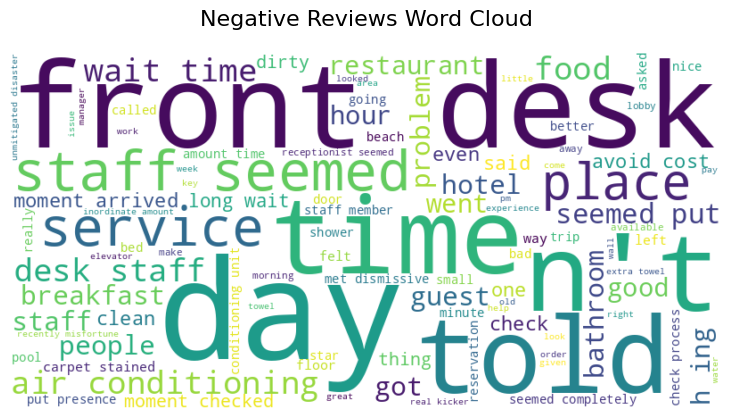

{'day': 1.0,
 'front desk': 0.9272300469483568,
 "n't": 0.7918622848200313,
 'time': 0.7582159624413145,
 'told': 0.7550860719874805,
 'staff seemed': 0.704225352112676,
 'service': 0.6572769953051644,
 'place': 0.568075117370892,
 'air conditioning': 0.5125195618153364,
 'food': 0.5015649452269171,
 'wait time': 0.48826291079812206,
 'desk staff': 0.48513302034428796,
 'seemed put': 0.44835680751173707,
 'breakfast': 0.4225352112676056,
 'problem': 0.41471048513302033,
 'people': 0.40923317683881066,
 'guest': 0.3982785602503912,
 'got': 0.39593114241001565,
 'staff': 0.38810641627543035,
 'hotel': 0.3865414710485133,
 'bathroom': 0.38497652582159625,
 'good': 0.36384976525821594,
 'restaurant': 0.36071987480438183,
 'hour': 0.3591549295774648,
 'h ing': 0.35837245696400627,
 'went': 0.35289514866979654,
 'moment arrived': 0.34820031298904536,
 'avoid cost': 0.3427230046948357,
 'one': 0.3302034428794992,
 'said': 0.32942097026604067,
 'check': 0.32472613458528954,
 'even': 0.32394366

In [19]:
create_rating_wordcloud(dataset, 
    rating=1,
    #colormap='Reds',
    title='Negative Reviews Word Cloud')

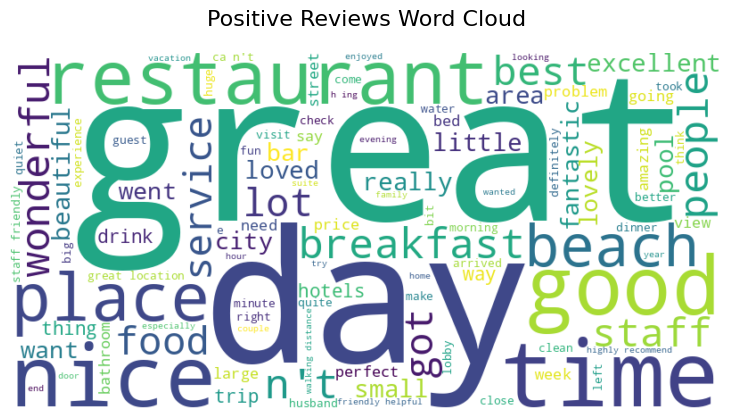

{'great': 1.0,
 'day': 0.9314802844214609,
 'time': 0.7999353587588882,
 'nice': 0.7032967032967034,
 'good': 0.6305753070458953,
 'restaurant': 0.5817711700064642,
 'place': 0.5665804783451842,
 'beach': 0.5290885585003232,
 'breakfast': 0.5012928248222366,
 "n't": 0.47640594699418226,
 'wonderful': 0.47285067873303166,
 'people': 0.46864899806076277,
 'best': 0.4528118939883646,
 'staff': 0.4495798319327731,
 'food': 0.4269553975436328,
 'lot': 0.4246929541047188,
 'service': 0.416289592760181,
 'got': 0.4114414996767938,
 'excellent': 0.4101486748545572,
 'loved': 0.40562378797672916,
 'pool': 0.40271493212669685,
 'area': 0.396574014221073,
 'beautiful': 0.39528118939883644,
 'small': 0.38978668390433097,
 'really': 0.3836457659987072,
 'little': 0.3778280542986425,
 'fantastic': 0.3532643826761474,
 'lovely': 0.34615384615384615,
 'bar': 0.3393665158371041,
 'city': 0.33775048480930836,
 'went': 0.33096315449256625,
 'want': 0.32094376212023273,
 'thing': 0.31997414350355524,
 'wa

In [125]:
create_rating_wordcloud(dataset, 
    rating=5,
    #colormap='Reds',
    title='Positive Reviews Word Cloud')

/tmp/ipykernel_323689/1193995465.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset, x='rating', ax=ax1, palette=palette)


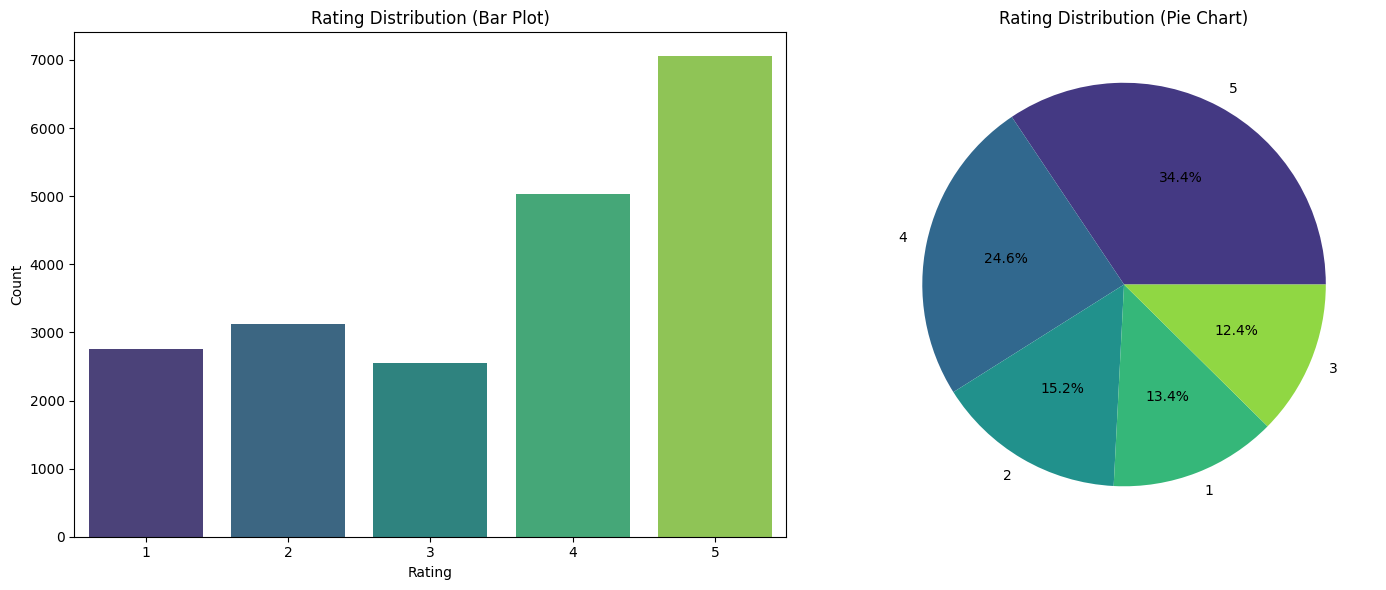


Numerical Summary:
rating
1    2751
2    3123
3    2544
4    5037
5    7053
Name: count, dtype: int64

Percentage Distribution:
rating
1    13.4
2    15.2
3    12.4
4    24.6
5    34.4
Name: proportion, dtype: float64


In [21]:
summaries = plot_rating_distribution(df)